### 学长可以重点关注黑体字和可视化部分，我顺便请假一些问题：
 - 问题1： EEG数据在训练前做归一化合适吗？
 - 问题2： 30Hz低通滤波后，频谱图显示上仍有>30hZ的成分，这正常吗？
 - 问题3： ICA结果看出，并没有很明显的EOG伪迹，这个时候ICA还可以怎么利用呢？

### 备注
 - 14个关于EEG的电极中，中只有7个是有价值的电极，其他或者为参考电极或者有故障。
 - 流程：
     - 高通滤波(0.1Hz) 
     - ICA (这里好像没用)
     - 小波包分解重构

In [27]:
import mne
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import os
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from sklearn import preprocessing
import pywt

### 1 读入数据、转化为raw类型

In [28]:
path = r"..\..\EEG Data\eeg_record11.mat"
file = scipy.io.loadmat(path) #文件读入字典
data = np.transpose(file['o']['data'][0][0][:, 3:17])

In [29]:
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
useful_channels = ['F7','F3','P7','O1','O2','P8','AF4']
#useful_channels = ['F7','F3','T7','P7','O1','O2','P8','T8','AF4']
use_channel_inds = []
for c in useful_channels:
    if c in channels:
        use_channel_inds.append(channels.index(c))
data = data[use_channel_inds]

In [26]:
# 各通道数据归一化
eeg_max = np.amax(data, 1)
eeg_min = np.min(data, 1)
eeg_mean = np.mean(data, 1)

for i in range(len(data)):
    data[i] = (data[i] - eeg_min[i])/(eeg_max[i] - eeg_min[i])

In [62]:
"""
创建info结构,
内容包括：通道名称和通道类型
设置采样频率为:sfreq=100
"""
# channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
info = mne.create_info(
    ch_names=[str(i) for i in range(len(useful_channels))],
    ch_types= ['eeg' for _ in range(len(useful_channels))],
    sfreq=128
)

"""
利用mne.io.RawArray类创建Raw对象
注意raw类型中的data为[channels, times]，因此这边要转置usefulData
"""
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=7, n_times=391624
    Range : 0 ... 391623 =      0.000 ...  3059.555 secs
Ready.


In [30]:
fs = 128
fs_highpass = 5
fs_lowpass = 40

In [31]:
data.shape

(7, 391624)

In [32]:
data

array([[3959.48717949, 3956.41025641, 3943.07692308, ..., 3986.15384615,
        3989.74358974, 3991.28205128],
       [5058.46153846, 5052.82051282, 5041.02564103, ..., 5055.38461538,
        5055.38461538, 5050.76923077],
       [4303.58974359, 4296.41025641, 4284.1025641 , ..., 4321.02564103,
        4321.53846154, 4324.1025641 ],
       ...,
       [4043.58974359, 4027.69230769, 4016.92307692, ..., 4054.35897436,
        4054.35897436, 4057.43589744],
       [4172.82051282, 4162.56410256, 4151.28205128, ..., 4145.64102564,
        4142.05128205, 4138.97435897],
       [4123.58974359, 4123.07692308, 4120.        , ..., 4107.69230769,
        4105.64102564, 4105.64102564]])

In [58]:
import scipy
wn1 = 2 * fs_highpass / fs
wn2 = 2 * fs_lowpass / fs
b, a = scipy.signal.butter(8, [wn1, wn2], 'bandpass')  # 配置滤波器 8 表示滤波器的阶数
bandPassedData = scipy.signal.filtfilt(b, a, data)  # data为要过滤的信号

In [59]:
bandPassedData

array([[ -0.33173968,  -3.17601687, -11.85947177, ...,  -2.48714216,
         -1.19967488,   0.70240715],
       [ -0.61770986,  -6.48175882, -14.30928775, ...,   3.8906923 ,
          4.99347678,   0.83341815],
       [ -0.37700502,  -5.90190649, -14.92896172, ...,  -1.28213369,
         -1.00086336,   0.8896742 ],
       ...,
       [ -0.66906984, -14.01119889, -21.26608524, ...,  -0.9569961 ,
         -1.01580281,   1.13074487],
       [ -0.8255622 , -10.86712418, -18.79803395, ...,   7.55045147,
          3.20717616,   1.15333843],
       [ -0.69126969,  -5.47189574,  -9.38148864, ...,   0.94193281,
          0.85011923,   0.75718198]])

In [51]:
info = mne.create_info(
    ch_names=[str(i) for i in range(len(data))],
    sfreq=128
)

"""
利用mne.io.RawArray类创建Raw对象
注意raw类型中的data为[channels, times]，因此这边要转置usefulData
"""
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=7, n_times=391624
    Range : 0 ... 391623 =      0.000 ...  3059.555 secs
Ready.


In [55]:
bandPassedData

array([[ 0.00000000e+00, -2.35927803e+00, -1.23921759e+01, ...,
        -3.13193499e+00, -8.10342387e-01,  8.88178420e-16],
       [-4.21884749e-15, -4.77533119e+00, -1.41489878e+01, ...,
         3.70599150e+00,  4.27904972e+00,  1.77635684e-15],
       [-2.66453526e-15, -4.97549464e+00, -1.54885817e+01, ...,
        -1.16697084e+00, -9.72879491e-01,  1.77635684e-15],
       ...,
       [-4.44089210e-16, -1.31293581e+01, -2.03541418e+01, ...,
        -7.30195541e-01, -1.72536316e+00,  0.00000000e+00],
       [ 1.77635684e-15, -9.07254052e+00, -1.72459386e+01, ...,
         7.75871292e+00,  2.85147527e+00,  3.10862447e-15],
       [-1.77635684e-15, -2.62188676e+00, -7.62117100e+00, ...,
         5.97043790e-01, -7.73543209e-01,  2.88657986e-15]])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 213 samples (1.664 sec)

完成
Effective window size : 16.000 (s)


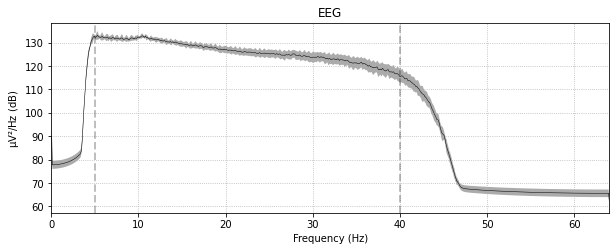

In [63]:
raw.filter(fs_highpass, fs_lowpass, fir_design='firwin')
print("完成")
fig = raw.plot_psd(average=True)
bandPassedData = raw.get_data()

Creating RawArray with float64 data, n_channels=7, n_times=391624
    Range : 0 ... 391623 =      0.000 ...  3059.555 secs
Ready.
完成
Effective window size : 16.000 (s)


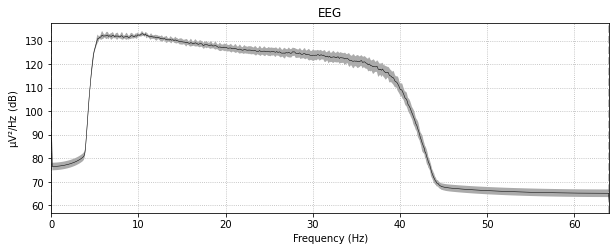

In [61]:
raw = mne.io.RawArray(bandPassedData, info)
print("完成")
fig = raw.plot_psd(average=True)
bandPassedData = raw.get_data()

D:\Apps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 181 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Apps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 181 missing from current font.
  font.set_text(s, 0, flags=flags)


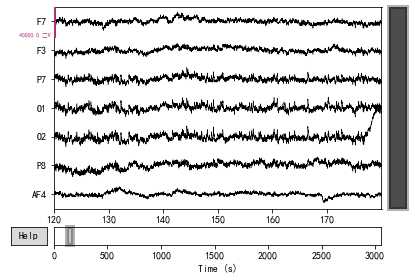

In [116]:
#数据缩小
scalings = {'eeg':0.02}
raw.plot(start = 120,
         duration = 60,
        scalings=scalings,
         title='scaled Data from arrays',
         show=True, block=True)
plt.show()

### 2  滤波

##### 2.1 查看频谱图

Effective window size : 16.000 (s)


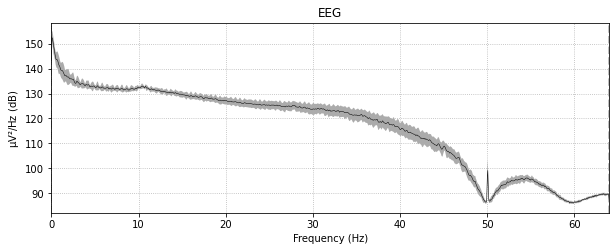

In [12]:
fig = raw.plot_psd(average=True)

 - 存在低频漂移、10-20Hz眼电伪迹、50Hz工频干扰等情况

##### 2.2 工频滤波

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 sec)

Effective window size : 16.000 (s)


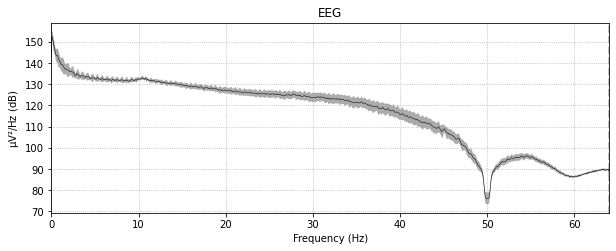

In [13]:
# 50Hz工频滤波
raw = raw.notch_filter(freqs=50)
fig = raw.plot_psd(average=True)

##### 2.3 高低通滤波

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (6.602 sec)

完成
Effective window size : 16.000 (s)


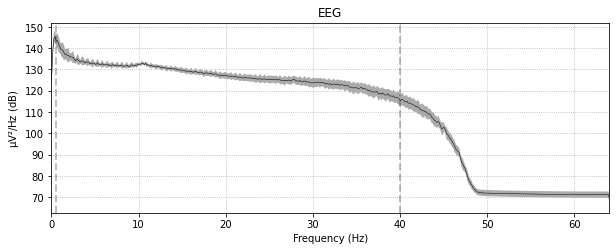

In [14]:
raw.filter(0.5, 40, fir_design='firwin')
print("完成")
fig = raw.plot_psd(average=True)

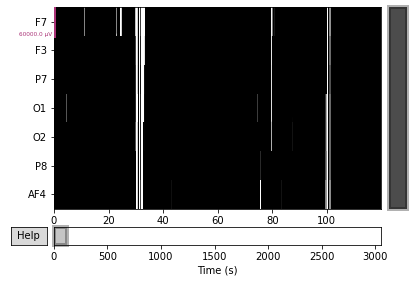

In [15]:
# 观察滤波后的数据
scalings = {'eeg':0.03}
raw.plot(duration = 120,
        scalings=scalings,
         title='Data After filtering',
         show=True, block=True)
plt.show()

### 3 ICA

#### 3.1 独立成分分析

<ipython-input-45-a028c2fdd7c5>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components=0.95, random_state=97)


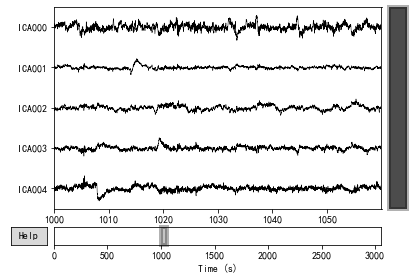

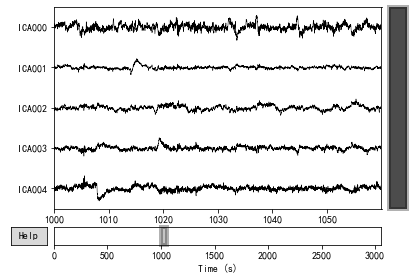

In [45]:
ica = ICA(n_components=0.95, random_state=97)
ica.fit(raw)
ica.plot_sources(raw, start = 1000, stop = 1060)  # stop 控制窗体长度

In [16]:
data = raw.get_data()

In [29]:
# # 看看去除伪迹后的数据
# ica.plot_overlay(raw, exclude=[3], picks='eeg')

##### 3.2 手动去除伪迹

In [30]:
# ica.exclude = [4]
# reconst_raw = raw.copy()
# ica.apply(reconst_raw)
# print("ok")

##### 3.3 自动去除伪迹
 - 由于数据集作者明确表示没有测eyes blinks，因此不考虑
 - 在之后我们的实验中，可以加一个EOG和ECG通道，这样就可以用

In [ ]:
# 去眼电伪迹

ica.exclude = []
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices
#与ICA成分中与EOG模式匹配得分的柱状图
ica.plot_scores(eog_scores)
#画出原数据主成分，与EOG匹配的成分高亮
ica.plot_sources(raw)


In [ ]:
# 去心电伪迹

ica.exclude = []
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method='correlation', threshold='auto')
ica.exclude = ecg_indices
#匹配得分图
ica.plot_scores(ecg_scores)
#匹配成分
ica.plot_sources(raw)
#诊断图
ica.plot_properties(raw, picks=ecg_indices)
#平均ECG epochs
ica.plot_sources(ecg_evoked)


### 4 小波包分解重构
 - 另一个思路是，用小波包分解重构，

In [139]:
def WPFilter(data, fs, wavelet, maxlevel = 6):
    wp = pywt.WaveletPacket(data=data, wavelet=wavelet, mode='symmetric')
    # 频谱由低到高的对应关系，这里需要注意小波变换的频带排列默认并不是顺序排列，所以这里需要使用’freq‘排序。
    freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
    # 构造空的小波包
    new_wp = pywt.WaveletPacket(data=None, wavelet=wavelet, mode='symmetric')
    # 计算maxlevel最小频段的带宽
    freqBand = fs/(2**maxlevel)
    for i in range(len(freqTree)):
        # 第i个频段的最小频率
        bandMin = i * freqBand
        # 第i个频段的最大频率
        bandMax = bandMin + freqBand
        # 判断第i个频段是否在要分析的范围内
        if (0<=bandMin and 30>= bandMax):
            # 给新构造的小波包参数赋值
            new_wp[freqTree[i]] = wp[freqTree[i]].data
    return new_wp.reconstruct()

In [178]:
tmp1 = [list(data[0])]
tmp2 = [list(data[1])]

In [179]:
tmp1.extend(tmp2)

In [182]:
np.array(tmp1)

array([[0.8437574 , 0.84304667, 0.83996683, ..., 0.84991708, 0.85074627,
        0.85110163],
       [0.90384995, 0.90276407, 0.90049358, ..., 0.90325765, 0.90325765,
        0.9023692 ]])

In [167]:
a = tmp.extend(tmp)
a

In [171]:
tmp.extend(test.tolist())

In [152]:
test = WPFilter(data[1], 128, 'db30', maxlevel = 6)

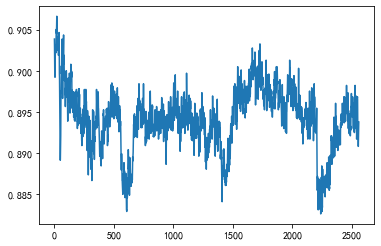

In [153]:
plt.plot(data[1][:128*20])

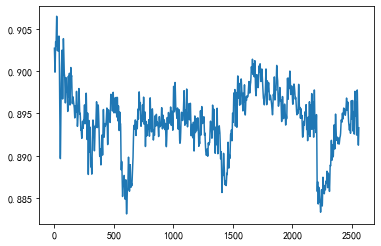

In [154]:
plt.plot(test[:128*20])

### 附1：小波分解、降噪、重构
 - 可以用于过滤波段中幅值太低or太高的部分，使得波段更均匀、平滑。
 - 这里没使用

In [126]:
# Create wavelet object and define parameters
test = data[0].tolist()    # 很离谱，这里要把np.array()转化成list才能用于wavedec函数
w = pywt.Wavelet('db8')  # 选用Daubechies8小波
maxlev = pywt.dwt_max_level(len(test), w.dec_len)
print("maximum level is " + str(maxlev))
threshold = 0.04  # Threshold for filtering

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(test, 'db8', level=maxlev)  # 将信号进行小波分解

plt.figure()
for i in range(len(coeffs)):
    coeffs[i] = pywt.threshold(data = coeffs[i], value = threshold*max(coeffs[i]), mode='soft', substitute=0)  # 将噪声滤波

datarec = pywt.waverec(coeffs, 'db8')  # 将信号进行小波重构

maximum level is 14


<Figure size 432x288 with 0 Axes>

### 附2 小波包分解重构得到各频段的波
 - 用小波包分解出Delta、Theta、Alpha和Beta频段的波，之后可以做特征提取等操作。
 - 这里未使用

In [11]:
# 需要分析的四个频段
iter_freqs = [
    {'name': 'Delta', 'fmin': 0, 'fmax': 4},
    {'name': 'Theta', 'fmin': 4, 'fmax': 8},
    {'name': 'Alpha', 'fmin': 8, 'fmax': 13},
    {'name': 'Beta', 'fmin': 13, 'fmax': 35},
]

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
mne.set_log_level(False)
#############################################小波包计算四个频段的能量分布
def WPEnergy(data, fs, wavelet, fmax=40, bins=0.5, maxlevel=6):
    # 小波包分解
    wp = pywt.WaveletPacket(data=data, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    # 频谱由低到高的对应关系，这里需要注意小波变换的频带排列默认并不是顺序排列，所以这里需要使用’freq‘排序。
    freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
    # 计算maxlevel最小频段的带宽
    freqBand = fs / (2 ** maxlevel)
    # 定义能量数组
    energy = []
    # 循环遍历计算四个频段对应的能量

    for iter in range(len(iter_freqs)):
        iterEnergy = 0.0
        for i in range(len(freqTree)):
            # 第i个频段的最小频率
            bandMin = i * freqBand
            # 第i个频段的最大频率
            bandMax = bandMin + freqBand
            # 判断第i个频段是否在要分析的范围内
            if (iter_freqs[iter]['fmin'] <= bandMin and iter_freqs[iter]['fmax'] >= bandMax):
                # 计算对应频段的累加和
                iterEnergy += pow(np.linalg.norm(wp[freqTree[i]].data, ord=None), 2)
        # 保存四个频段对应的能量和
        energy.append(iterEnergy)
    # 绘制能量分布图
    plt.plot([xLabel['name'] for xLabel in iter_freqs], energy, lw=0, marker='o')
    plt.title('能量分布')
    plt.show()

In [172]:
def getTimeSpectrum(data, wavelet='db4',maxlevel = 8, fs=128, fmax = 40, interval = 10):
    freqBand = fs / (2 ** maxlevel)
    window_num = int(fmax / freqBand)
    # 10s 一分区  
    size = int(len(data)/ fs / interval)
    energy = []
    for i in range(size):
        head = i*fs*interval
        tail = head + interval*fs
        wp = pywt.WaveletPacket(data=data[head:tail], wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
        freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
        # 初始化该通道下每个频带的能量数组
        iterEnergy = []
        # 对于每一个频带
        for j in range(1, window_num):
            iterEnergy.append(pow(np.linalg.norm(wp[freqTree[j]].data, ord=None), 2))
        # 合并
        energy.append(iterEnergy)
    # 对每一个频道内的数据归一化
#     min_max_scaler = preprocessing.MinMaxScaler()  
#     energy = min_max_scaler.fit_transform(energy)
#     # 对每一个船体时间内的数据进行归一化  效果很不好，别这样搞
#     min_max_scaler = preprocessing.MinMaxScaler()  
#     energy = min_max_scaler.fit_transform(np.transpose(energy))
#     energy = np.transpose(energy)
    return energy

In [258]:
data.shape

(7, 391624)

In [290]:
energy = getTimeSpectrum(data[6][:30*60*128], wavelet='db4',maxlevel = 8, fs=128, fmax = 40, interval = 10)

In [291]:
energy = np.array(energy)

In [292]:
blocksize = int(np.shape(energy)[0] / 3)
id=1
E1 = energy[:blocksize]
E2 = energy[blocksize:blocksize*2]
E3 = energy[blocksize*2:]

In [293]:
E1_avg = E1.mean(axis=0)
E2_avg = E2.mean(axis=0)
E3_avg = E3.mean(axis=0)

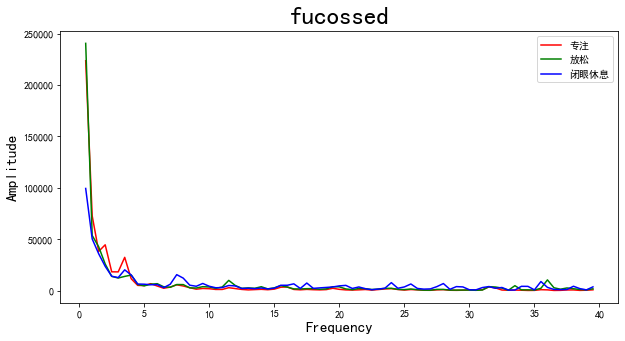

In [294]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.figure(figsize=(10,5))
plt.title('fucossed', fontsize=25)
plt.xlabel('Frequency',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.plot([i/2 for i in range(1,80)],E1_avg,color = 'red',label = '专注')
plt.plot([i/2 for i in range(1,80)],E2_avg,color = 'green',label='放松')
plt.plot([i/2 for i in range(1,80)],E3_avg,color = 'blue',label = '闭眼休息')
plt.legend()
plt.show()

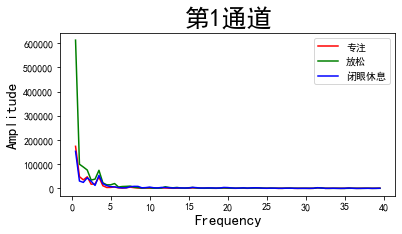

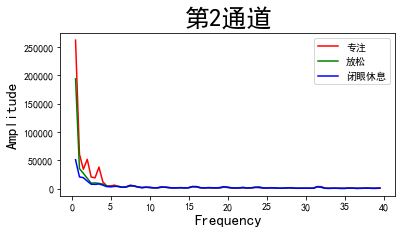

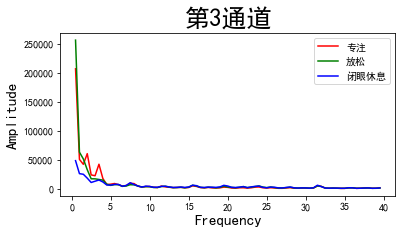

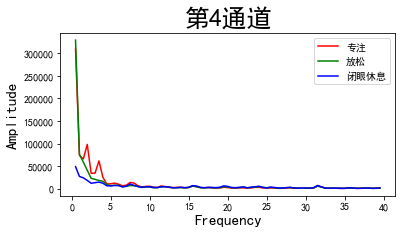

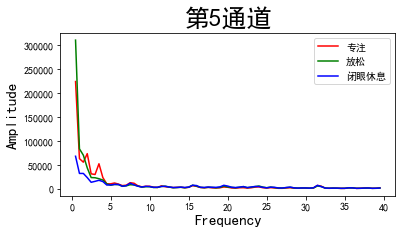

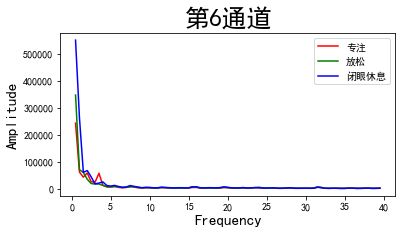

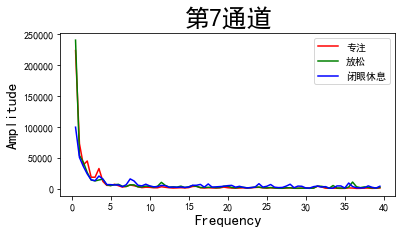

In [306]:
for channel in range(7):
    energy = getTimeSpectrum(data[channel][:30*60*128], wavelet='db4',maxlevel = 8, fs=128, fmax = 40, interval = 10)
    energy = np.array(energy)
    blocksize = int(np.shape(energy)[0] / 3)
    id=1
    E1 = energy[:blocksize]
    E2 = energy[blocksize:blocksize*2]
    E3 = energy[blocksize*2:]
    
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
    plt.figure(figsize=(6,3))
    plt.title('第{0}通道'.format(channel+1), fontsize=25)
    plt.xlabel('Frequency',fontsize=15)
    plt.ylabel('Amplitude',fontsize=15)
    
    E1_avg = E1.mean(axis=0)
    E2_avg = E2.mean(axis=0)
    E3_avg = E3.mean(axis=0)
    
    plt.plot([i/2 for i in range(1,80)],E1_avg,color = 'red',label = '专注')
    plt.plot([i/2 for i in range(1,80)],E2_avg,color = 'green',label='放松')
    plt.plot([i/2 for i in range(1,80)],E3_avg,color = 'blue',label = '闭眼休息')
    plt.legend()
    plt.show()

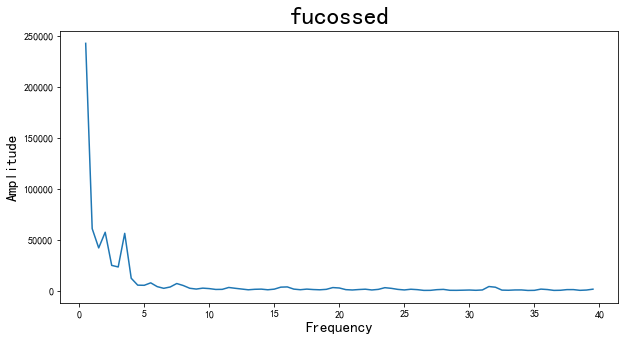

In [289]:
plt.figure(figsize=(10,5))
plt.title('fucossed', fontsize=25)
plt.xlabel('Frequency',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.plot([i/2 for i in range(1,80)],E1_avg)
plt.show()

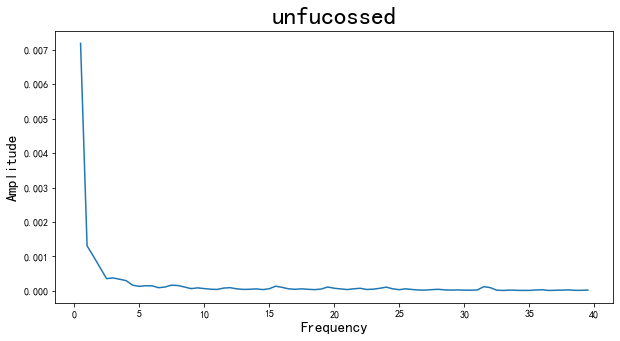

In [150]:
plt.figure(figsize=(10,5))
plt.title('unfucossed', fontsize=25)
plt.xlabel('Frequency',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.plot([i/2 for i in range(1,80)],E2_avg)
plt.show()

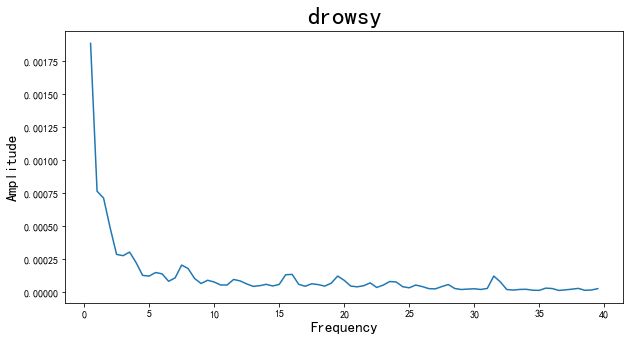

In [151]:
plt.figure(figsize=(10,5))
plt.title('drowsy', fontsize=25)
plt.xlabel('Frequency',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.plot([i/2 for i in range(1,80)],E3_avg)
plt.show()

In [48]:
len(data[1][:30*128*60])

230400

In [73]:
energy = []

In [74]:
iterEnergy = [1,2,3,4]

In [77]:
energy.append(iterEnergy)

In [78]:
energy

[[1, 2, 3, 4], [1, 2, 3, 4]]

In [61]:
data[1][1:2]

array([-8.2543905])

In [ ]:
# 每四秒计算一次 0-40hZ 0.5bin下的能量，最终返回[n, 80,导联数]

In [49]:
wp = pywt.WaveletPacket(data=data[1][:30*128*60], wavelet='db4', mode='symmetric', maxlevel=6)

In [60]:
len(wp['aaaa'].data)

14406

In [54]:
[node.path for node in wp.get_level(6, 'freq')]

['aaaaaa',
 'aaaaad',
 'aaaadd',
 'aaaada',
 'aaadda',
 'aaaddd',
 'aaadad',
 'aaadaa',
 'aaddaa',
 'aaddad',
 'aadddd',
 'aaddda',
 'aadada',
 'aadadd',
 'aadaad',
 'aadaaa',
 'addaaa',
 'addaad',
 'addadd',
 'addada',
 'adddda',
 'addddd',
 'adddad',
 'adddaa',
 'adadaa',
 'adadad',
 'adaddd',
 'adadda',
 'adaada',
 'adaadd',
 'adaaad',
 'adaaaa',
 'ddaaaa',
 'ddaaad',
 'ddaadd',
 'ddaada',
 'ddadda',
 'ddaddd',
 'ddadad',
 'ddadaa',
 'ddddaa',
 'ddddad',
 'dddddd',
 'ddddda',
 'dddada',
 'dddadd',
 'dddaad',
 'dddaaa',
 'dadaaa',
 'dadaad',
 'dadadd',
 'dadada',
 'daddda',
 'dadddd',
 'daddad',
 'daddaa',
 'daadaa',
 'daadad',
 'daaddd',
 'daadda',
 'daaada',
 'daaadd',
 'daaaad',
 'daaaaa']

In [40]:
pow(np.array([0,1,2,3,4,5]), 2)

array([ 0,  1,  4,  9, 16, 25], dtype=int32)

In [42]:
np.linalg.norm([1,2], ord=None)

2.23606797749979

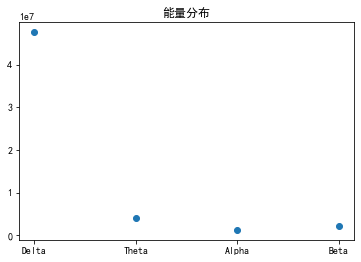

In [37]:
test = WPEnergy(data[3][:128*60*10], 128, 'db4', maxlevel = 8)

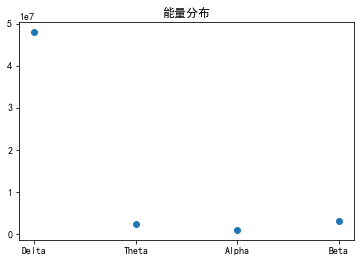

In [38]:
test = WPEnergy(data[3][t1:t2], 128, 'db30', maxlevel = 6)

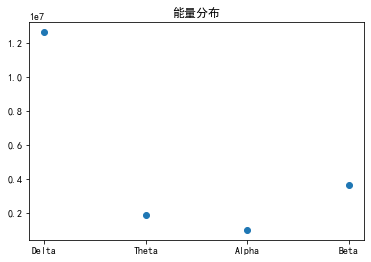

In [39]:
WPEnergy(data[3][t2:t3], 128, 'db30', maxlevel = 6)

In [30]:
t1 = 128*60*10
t2 = 128*60*20
t3 = 128*60*30

In [93]:
def getTimeSpectrum(data, wavelet='db4',maxlevel = 8, fs=128, fmax = 40, interval = 10):
    freqBand = fs / (2 ** maxlevel)
    # 10s 一分区  
    size = int(len(data)/ fs / interval)
    energy = []
    for i in range(size):
        head = i*fs*interval
        tail = head + interval*fs
        wp = pywt.WaveletPacket(data=data[head:tail], wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
        freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
        # 初始化该通道下每个频带的能量数组
        iterEnergy = []
        # 对于每一个频带
        for j in range(1, 80):
            iterEnergy.append(pow(np.linalg.norm(wp[freqTree[j]].data, ord=None), 2))
        # 合并
        energy.append(iterEnergy)
    # 归一化
    min_max_scaler = preprocessing.MinMaxScaler()  
    energy = min_max_scaler.fit_transform(energy)  
    return energy

In [94]:
getTimeSpectrum(data[0], wavelet='db4',maxlevel = 8, fs=128, fmax = 40, interval = 10)

array([[0.00122802, 0.00391428, 0.00257374, ..., 0.00181151, 0.00468815,
        0.0018149 ],
       [0.00650069, 0.00423768, 0.00457726, ..., 0.00758972, 0.00980636,
        0.00193522],
       [0.01495031, 0.02152813, 0.023234  , ..., 0.00227648, 0.00165273,
        0.0012529 ],
       ...,
       [0.00047092, 0.00733122, 0.00348385, ..., 0.00457588, 0.00174884,
        0.00209225],
       [0.00104006, 0.01114794, 0.00203726, ..., 0.00430267, 0.0070245 ,
        0.00051018],
       [0.00278796, 0.02043077, 0.03235914, ..., 0.04743912, 0.00894362,
        0.00399237]])

In [9]:
np.shape(data)

(14, 391624)

In [10]:
d = data[0]
np.shape(d)

(391624,)

In [13]:
fs =  128
t = np.arange(d.shape[0])/fs

In [16]:
fs =  128
wavelet = 'db4'
# 采样数据的时间维度
t = np.arange(d.shape[0])/fs

# 中心频率
wcf = pywt.central_frequency(wavelet=wavelet)

In [18]:
totalscal = 100
# 计算对应频率的小波尺度
cparam = 2 * wcf * totalscal
scales = cparam/np.arange(totalscal, 1, -1)

# 附：用于特征提取的数据

In [ ]:
def getTimeSpectrum(data, wavelet='db4',maxlevel = 8, fs=128, fmax = 40, interval = 8, step = 2, bins = 0.5 ):
    freqBand = fs / (2 ** maxlevel)
    window_num = int(fmax / bins)
    
    # 10s 一分区  
    head = 0
    tail = head + interval*fs
    energy = []
    while (tail <= len(data)):
        wp = pywt.WaveletPacket(data=data[head:tail], wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
        freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
        # 初始化该通道下每个频带的能量数组
        iterEnergy = []
        # 对于每一个频带
        
        # 对于每一个频带循环，套件 i* freqBand<=fmax
            # 分箱号
        
        
#         for j in range(1, window_num):
            
#             while
            
#             iterEnergy.append(pow(np.linalg.norm(wp[freqTree[j]].data, ord=None), 2))


        # 合并
        energy.append(iterEnergy)
        # 修改指针
        head += step * fs
        tail = head + interval*fs
        
    min_max_scaler = preprocessing.MinMaxScaler()  
    energy = min_max_scaler.fit_transform(energy)
    #     # 对每一个船体时间内的数据进行归一化  效果很不好，别这样搞
#     min_max_scaler = preprocessing.MinMaxScaler()  
#     energy = min_max_scaler.fit_transform(np.transpose(energy))
#     energy = np.transpose(energy)
    return energy

In [120]:
maxlevel = 10 
fs=250
fmax = 40
interval = 8
step = 2

freqBand = fs / (2 ** maxlevel)
window_num = int(fmax / freqBand)


In [121]:
freqBand

0.244140625

In [122]:
window_num

163

In [19]:
cparam

142.85714285714286

In [48]:
wavelet = pywt.DiscreteContinuousWavelet('db4')

In [45]:
wavelet

pywt._extensions._pywt.ContinuousWavelet(name='gaus1')

In [107]:
d = data[1][:128*60]

In [108]:
fs =  128
totalscal = 100
wavelet = 'cgau8'
# 采样数据的时间维度
t = np.arange(d.shape[0])/fs

# 中心频率
wcf = pywt.central_frequency(wavelet=wavelet)

# 计算对应频率的小波尺度
cparam = 2 * wcf * totalscal
scales = cparam/np.arange(totalscal, 1, -1)

# 连续小波变换
[cwtmatr, frequencies] = pywt.cwt(d, scales, wavelet, 1.0/fs)

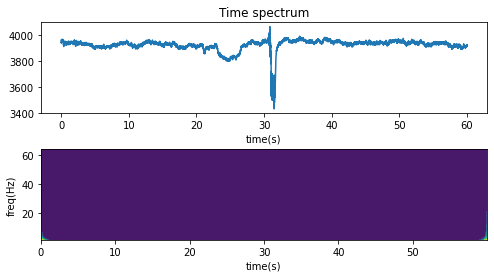

In [109]:
# 绘图
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(t, d)
plt.xlabel(u"time(s)")
plt.title(u"Time spectrum")
plt.subplot(212)
plt.contourf(t, frequencies, abs(cwtmatr))
plt.ylabel(u"freq(Hz)")
plt.xlabel(u"time(s)")
plt.subplots_adjust(hspace=0.4)
plt.show()

In [111]:
t = abs(cwtmatr)

In [112]:
np.shape(t)

(99, 7680)

In [113]:
t[0]

array([801.87115195, 608.42570398, 266.9495121 , ...,  67.38263747,
       263.87101544, 600.15458096])